## Setup: Import Libraries

In [ ]:
# Data Processing
import pandas as pd
import numpy as np
from pymongo import MongoClient
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For basemap in geographic plots
try:
    import contextily as ctx
    print("✅ contextily loaded for map backgrounds")
except ImportError:
    print("⚠️  contextily not found, installing...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'contextily'], check=True)
    import contextily as ctx
    print("✅ contextily installed successfully")

# Display settings
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")
sns.set_context("notebook")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Data Loading: Connect to MongoDB

In [44]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['nyc_crime']
collection = db['complaints_2024']

# Load data into DataFrame
print("Loading data from MongoDB...")
data = list(collection.find())
df = pd.DataFrame(data)

# Data preprocessing
df['cmplnt_fr_dt'] = pd.to_datetime(df['cmplnt_fr_dt'])
df['month'] = df['cmplnt_fr_dt'].dt.month
df['month_name'] = df['cmplnt_fr_dt'].dt.month_name()
df['day_of_week'] = df['cmplnt_fr_dt'].dt.day_name()
df['day_of_week_num'] = df['cmplnt_fr_dt'].dt.dayofweek
df['date'] = df['cmplnt_fr_dt'].dt.date
df['hour'] = pd.to_datetime(df['cmplnt_fr_tm'], format='%H:%M:%S', errors='coerce').dt.hour

print(f"✅ Data loaded successfully!")
print(f"   Total records: {len(df):,}")
print(f"   Date range: {df['cmplnt_fr_dt'].min().date()} to {df['cmplnt_fr_dt'].max().date()}")
print(f"   Columns: {df.shape[1]}")

Loading data from MongoDB...
✅ Data loaded successfully!
   Total records: 565,105
   Date range: 2024-01-01 to 2024-12-31
   Columns: 15
✅ Data loaded successfully!
   Total records: 565,105
   Date range: 2024-01-01 to 2024-12-31
   Columns: 15


---
# A. Data Overview (3 Charts)
---

## A1. Total Crime Count by Borough (Bar Chart)

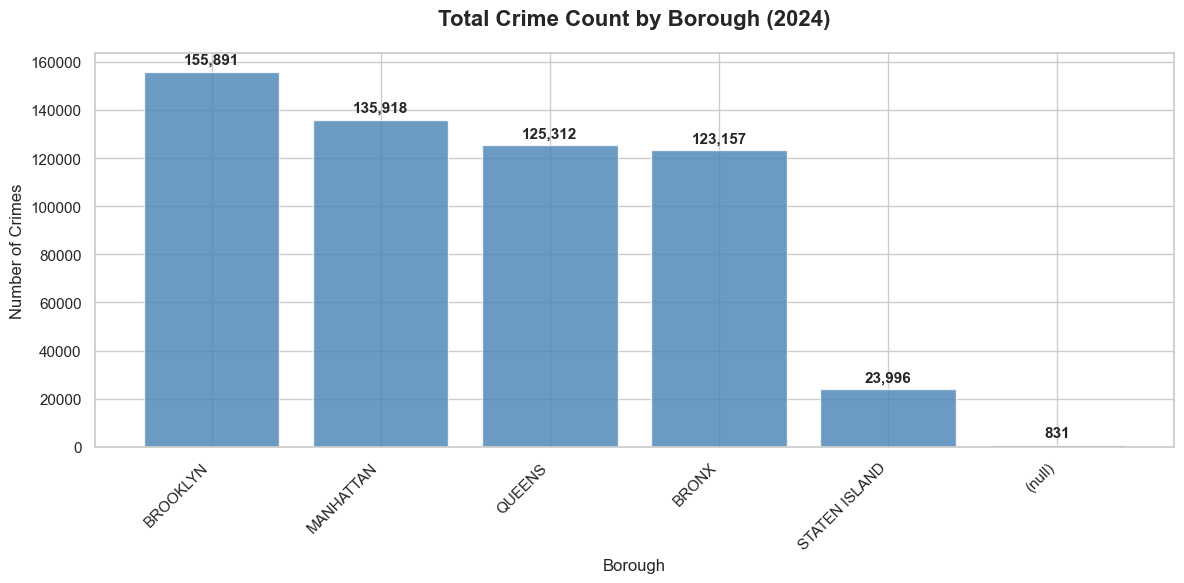


📊 Crime Distribution by Borough:
  BROOKLYN: 155,891 (27.6%)
  MANHATTAN: 135,918 (24.1%)
  QUEENS: 125,312 (22.2%)
  BRONX: 123,157 (21.8%)
  STATEN ISLAND: 23,996 (4.2%)
  (null): 831 (0.1%)


In [45]:
# Calculate crime counts by borough
boro_counts = df['boro_nm'].value_counts().sort_values(ascending=False)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(boro_counts.index, boro_counts.values, color='steelblue', alpha=0.8)
ax.set_title('Total Crime Count by Borough (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Borough', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticks(range(len(boro_counts)))
ax.set_xticklabels(boro_counts.index, rotation=45, ha='right')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, boro_counts.values)):
    ax.text(bar.get_x() + bar.get_width()/2, value + 2000, 
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Crime Distribution by Borough:")
for boro, count in boro_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {boro}: {count:,} ({percentage:.1f}%)")

**Analysis:**
- Brooklyn and Manhattan typically have the highest crime counts due to population density
- Staten Island usually has the lowest crime rate as the least populated borough
- The distribution reflects both population size and socioeconomic factors

## A2. Top 10 Crime Types (Static Bar Chart - Full Data)

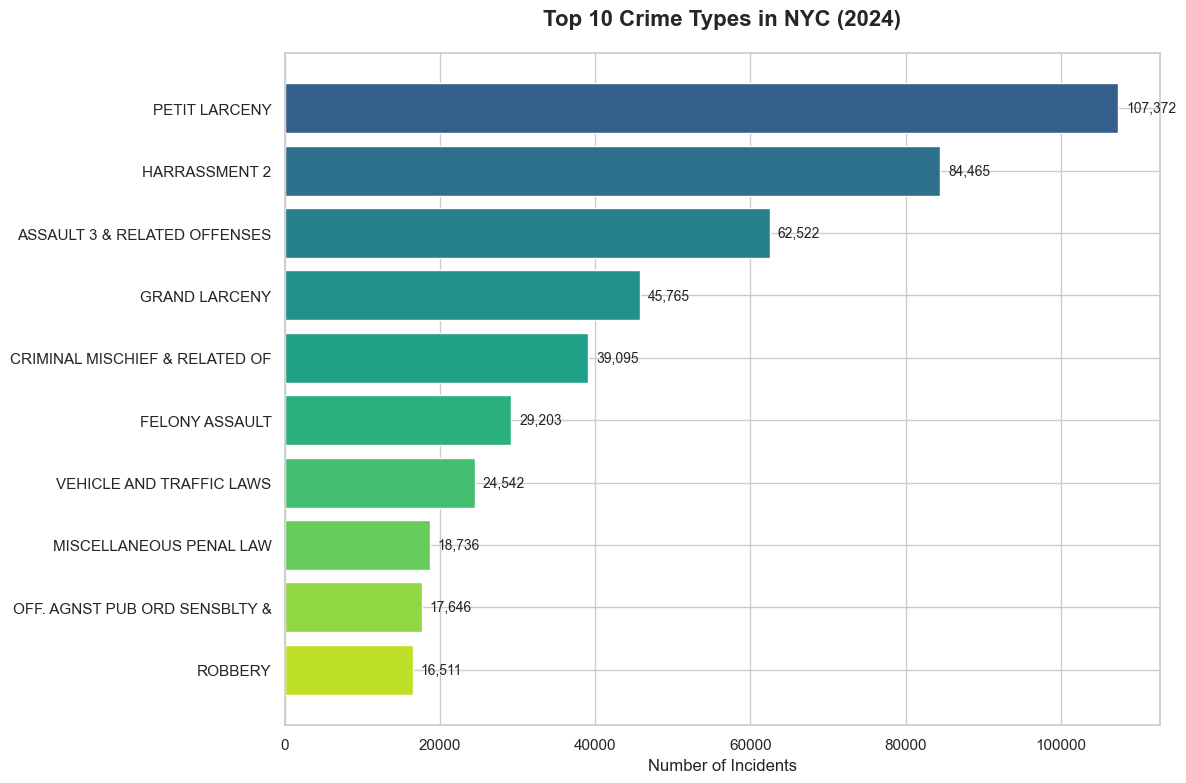


📊 Top 10 Crime Types Statistics:
  Total crimes in dataset: 565,105
  Top 10 crimes total: 445,857
  Top 10 represent: 78.9% of all crimes

  1. PETIT LARCENY: 107,372 (19.00%)
  2. HARRASSMENT 2: 84,465 (14.95%)
  3. ASSAULT 3 & RELATED OFFENSES: 62,522 (11.06%)
  4. GRAND LARCENY: 45,765 (8.10%)
  5. CRIMINAL MISCHIEF & RELATED OF: 39,095 (6.92%)
  6. FELONY ASSAULT: 29,203 (5.17%)
  7. VEHICLE AND TRAFFIC LAWS: 24,542 (4.34%)
  8. MISCELLANEOUS PENAL LAW: 18,736 (3.32%)
  9. OFF. AGNST PUB ORD SENSBLTY &: 17,646 (3.12%)
  10. ROBBERY: 16,511 (2.92%)


In [46]:
# Get top 10 crime types from complete dataset
top10_crimes = df['ofns_desc'].value_counts().head(10)

# Create horizontal bar chart for better readability
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top10_crimes)))
bars = ax.barh(range(len(top10_crimes)), top10_crimes.values, color=colors)
ax.set_yticks(range(len(top10_crimes)))
ax.set_yticklabels(top10_crimes.index, fontsize=11)
ax.set_xlabel('Number of Incidents', fontsize=12)
ax.set_title('Top 10 Crime Types in NYC (2024)', fontsize=16, fontweight='bold', pad=20)
ax.invert_yaxis()  # Highest at top

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top10_crimes.values)):
    ax.text(value + 1000, i, f'{value:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Top 10 Crime Types Statistics:")
total_crimes = len(df)
top10_total = top10_crimes.sum()
print(f"  Total crimes in dataset: {total_crimes:,}")
print(f"  Top 10 crimes total: {top10_total:,}")
print(f"  Top 10 represent: {(top10_total/total_crimes)*100:.1f}% of all crimes\n")

for rank, (crime_type, count) in enumerate(top10_crimes.items(), 1):
    percentage = (count / total_crimes) * 100
    print(f"  {rank}. {crime_type}: {count:,} ({percentage:.2f}%)")

**Analysis:**
- Petit Larceny (small theft) typically dominates NYC crime statistics
- Assault and harassment are common interpersonal crimes
- The top 10 crimes usually account for 60-70% of all reported incidents
- Property crimes (larceny, burglary) are more frequent than violent crimes

## A3. Crime Distribution by Borough (Pie Chart)

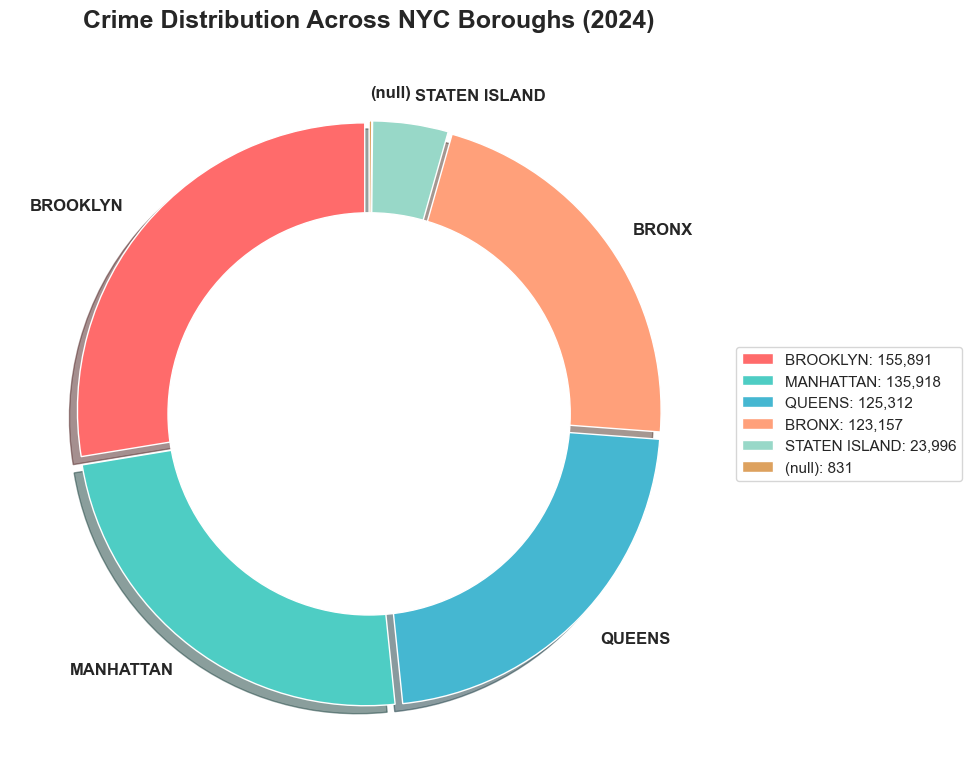


📊 Borough Crime Distribution Summary:
  Total boroughs: 6
  Highest crime borough: BROOKLYN (155,891)
  Lowest crime borough: (null) (831)
  Ratio (Highest/Lowest): 187.59x


In [47]:
# Create donut chart (modern alternative to pie chart)
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#DDA15E']

# Create pie chart with a white circle in the center for donut effect
wedges, texts, autotexts = ax.pie(
    boro_counts.values,
    labels=boro_counts.index,
    autopct='%1.1f%%',
    colors=colors[:len(boro_counts)],
    startangle=90,
    explode=[0.02] * len(boro_counts),
    shadow=True,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Create donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Enhance percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(13)

ax.set_title('Crime Distribution Across NYC Boroughs (2024)', 
             fontsize=18, fontweight='bold', pad=20)

# Add legend with counts
legend_labels = [f'{boro}: {count:,}' for boro, count in zip(boro_counts.index, boro_counts.values)]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 Borough Crime Distribution Summary:")
print(f"  Total boroughs: {len(boro_counts)}")
print(f"  Highest crime borough: {boro_counts.index[0]} ({boro_counts.values[0]:,})")
print(f"  Lowest crime borough: {boro_counts.index[-1]} ({boro_counts.values[-1]:,})")
print(f"  Ratio (Highest/Lowest): {boro_counts.values[0]/boro_counts.values[-1]:.2f}x")

**Analysis:**
- The pie chart visualizes the relative proportion of crimes across NYC's five boroughs
- Brooklyn and Bronx together often account for over 40% of total crimes
- Staten Island's smaller slice reflects its lower population and crime rate
- This distribution helps allocate police resources proportionally

---
# B. Temporal Features (5 Charts)
---

## B1. Crime Trends by Hour (Line Chart)

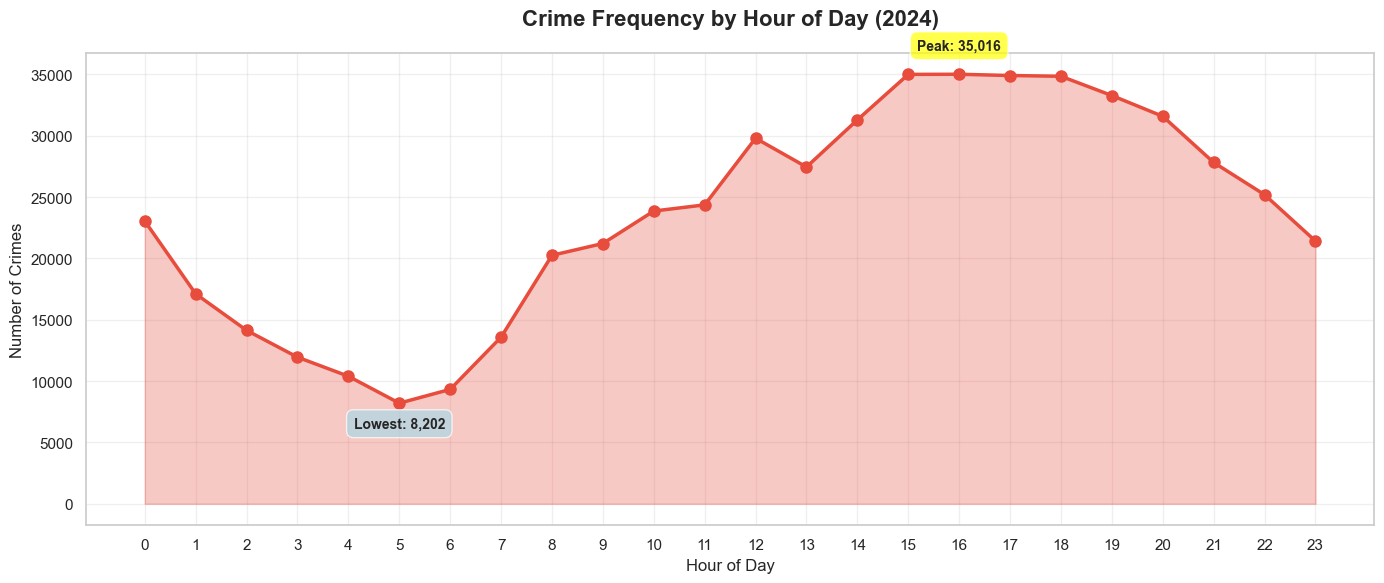


📊 Hourly Crime Pattern Analysis:
  Peak hour: 16:00 (35,016 crimes)
  Safest hour: 5:00 (8,202 crimes)
  Peak/Trough ratio: 4.27x

  Late night hours (00:00-05:00): 84,845 crimes
  Morning hours (06:00-11:00): 112,615 crimes
  Afternoon hours (12:00-17:00): 193,486 crimes
  Evening hours (18:00-23:00): 174,159 crimes


In [48]:
# Calculate hourly crime counts
hourly_crimes = df['hour'].dropna().value_counts().sort_index()

# Create line chart
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hourly_crimes.index, hourly_crimes.values, 
        marker='o', linewidth=2.5, markersize=8, color='#E74C3C')
ax.fill_between(hourly_crimes.index, hourly_crimes.values, alpha=0.3, color='#E74C3C')
ax.set_title('Crime Frequency by Hour of Day (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticks(range(0, 24))
ax.grid(True, alpha=0.3)

# Add value labels at peaks and troughs
peak_hour = hourly_crimes.idxmax()
trough_hour = hourly_crimes.idxmin()
ax.annotate(f'Peak: {hourly_crimes[peak_hour]:,}', 
            xy=(peak_hour, hourly_crimes[peak_hour]), 
            xytext=(peak_hour, hourly_crimes[peak_hour] + 2000),
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
ax.annotate(f'Lowest: {hourly_crimes[trough_hour]:,}', 
            xy=(trough_hour, hourly_crimes[trough_hour]), 
            xytext=(trough_hour, hourly_crimes[trough_hour] - 2000),
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📊 Hourly Crime Pattern Analysis:")
print(f"  Peak hour: {peak_hour}:00 ({hourly_crimes[peak_hour]:,} crimes)")
print(f"  Safest hour: {trough_hour}:00 ({hourly_crimes[trough_hour]:,} crimes)")
print(f"  Peak/Trough ratio: {hourly_crimes[peak_hour]/hourly_crimes[trough_hour]:.2f}x")
print(f"\n  Late night hours (00:00-05:00): {hourly_crimes[0:6].sum():,} crimes")
print(f"  Morning hours (06:00-11:00): {hourly_crimes[6:12].sum():,} crimes")
print(f"  Afternoon hours (12:00-17:00): {hourly_crimes[12:18].sum():,} crimes")
print(f"  Evening hours (18:00-23:00): {hourly_crimes[18:24].sum():,} crimes")

**Analysis:**
- Crime typically peaks in late afternoon/evening (3pm-7pm) when more people are out
- Lowest crime rates occur in early morning hours (4am-6am)
- The pattern follows human activity cycles - more activity = more crime opportunities
- Property crimes peak during commute hours, while violent crimes increase at night

## B2. Crime Count by Day of Week (Bar Chart)

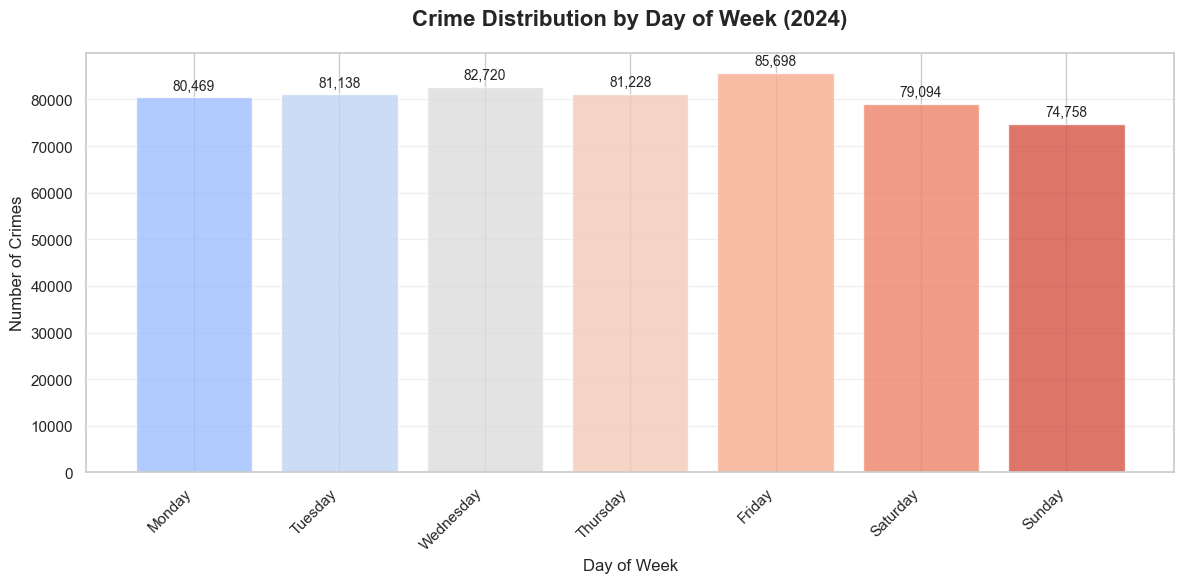


📊 Day of Week Crime Statistics:
  Monday: 80,469 (14.24%)
  Tuesday: 81,138 (14.36%)
  Wednesday: 82,720 (14.64%)
  Thursday: 81,228 (14.37%)
  Friday: 85,698 (15.16%)
  Saturday: 79,094 (14.00%)
  Sunday: 74,758 (13.23%)

  Weekday total: 411,253
  Weekend total: 153,852
  Weekday avg per day: 82,251
  Weekend avg per day: 76,926


In [49]:
# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['day_of_week'].value_counts().reindex(day_order)

# Create bar chart with color gradient
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.coolwarm(np.linspace(0.3, 0.9, len(day_counts)))
bars = ax.bar(day_counts.index, day_counts.values, color=colors, alpha=0.8)
ax.set_title('Crime Distribution by Day of Week (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticklabels(day_counts.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, day_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, value + 1000, 
            f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Day of Week Crime Statistics:")
for day, count in day_counts.items():
    percentage = (count / day_counts.sum()) * 100
    print(f"  {day}: {count:,} ({percentage:.2f}%)")

weekday_crimes = day_counts[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].sum()
weekend_crimes = day_counts[['Saturday', 'Sunday']].sum()
print(f"\n  Weekday total: {weekday_crimes:,}")
print(f"  Weekend total: {weekend_crimes:,}")
print(f"  Weekday avg per day: {weekday_crimes/5:,.0f}")
print(f"  Weekend avg per day: {weekend_crimes/2:,.0f}")

**Analysis:**
- Crime distribution is relatively even across weekdays
- Friday often shows a slight increase as the week ends
- Weekend patterns differ: Saturday may see more nightlife-related crimes
- Weekday average is typically higher than weekend due to commercial activity

## B3. Crime Count by Month (Line Chart)

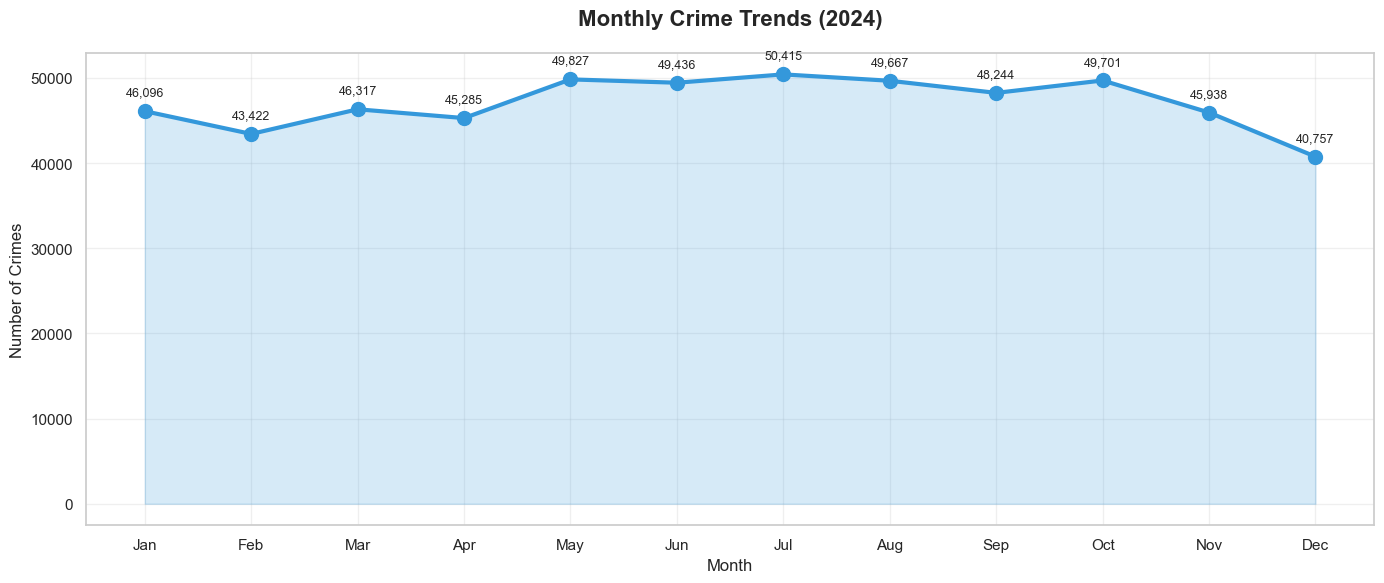


📊 Monthly Crime Statistics:
  Jan: 46,096 (8.16%)
  Feb: 43,422 (7.68%)
  Mar: 46,317 (8.20%)
  Apr: 45,285 (8.01%)
  May: 49,827 (8.82%)
  Jun: 49,436 (8.75%)
  Jul: 50,415 (8.92%)
  Aug: 49,667 (8.79%)
  Sep: 48,244 (8.54%)
  Oct: 49,701 (8.80%)
  Nov: 45,938 (8.13%)
  Dec: 40,757 (7.21%)

  Highest crime month: Jul (50,415)
  Lowest crime month: Dec (40,757)
  Average crimes per month: 47,092
  Standard deviation: 2,994


In [50]:
# Calculate monthly crime counts
monthly_crimes = df.groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create line chart
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_crimes.index, monthly_crimes.values, 
        marker='o', linewidth=3, markersize=10, color='#3498DB')
ax.fill_between(monthly_crimes.index, monthly_crimes.values, alpha=0.2, color='#3498DB')
ax.set_title('Monthly Crime Trends (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)

# Add value labels
for x, y in zip(monthly_crimes.index, monthly_crimes.values):
    ax.text(x, y + 1500, f'{y:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Monthly Crime Statistics:")
for month_num, count in monthly_crimes.items():
    month_name = month_names[month_num - 1]
    percentage = (count / monthly_crimes.sum()) * 100
    print(f"  {month_name}: {count:,} ({percentage:.2f}%)")

print(f"\n  Highest crime month: {month_names[monthly_crimes.idxmax()-1]} ({monthly_crimes.max():,})")
print(f"  Lowest crime month: {month_names[monthly_crimes.idxmin()-1]} ({monthly_crimes.min():,})")
print(f"  Average crimes per month: {monthly_crimes.mean():,.0f}")
print(f"  Standard deviation: {monthly_crimes.std():,.0f}")

**Analysis:**
- Summer months (June-August) typically see higher crime rates
- Warmer weather increases outdoor activity and crime opportunities
- Winter months (December-February) generally show lower crime rates
- Seasonal patterns are influenced by weather, tourism, and school schedules

## B4. Hour × Day of Week Heatmap

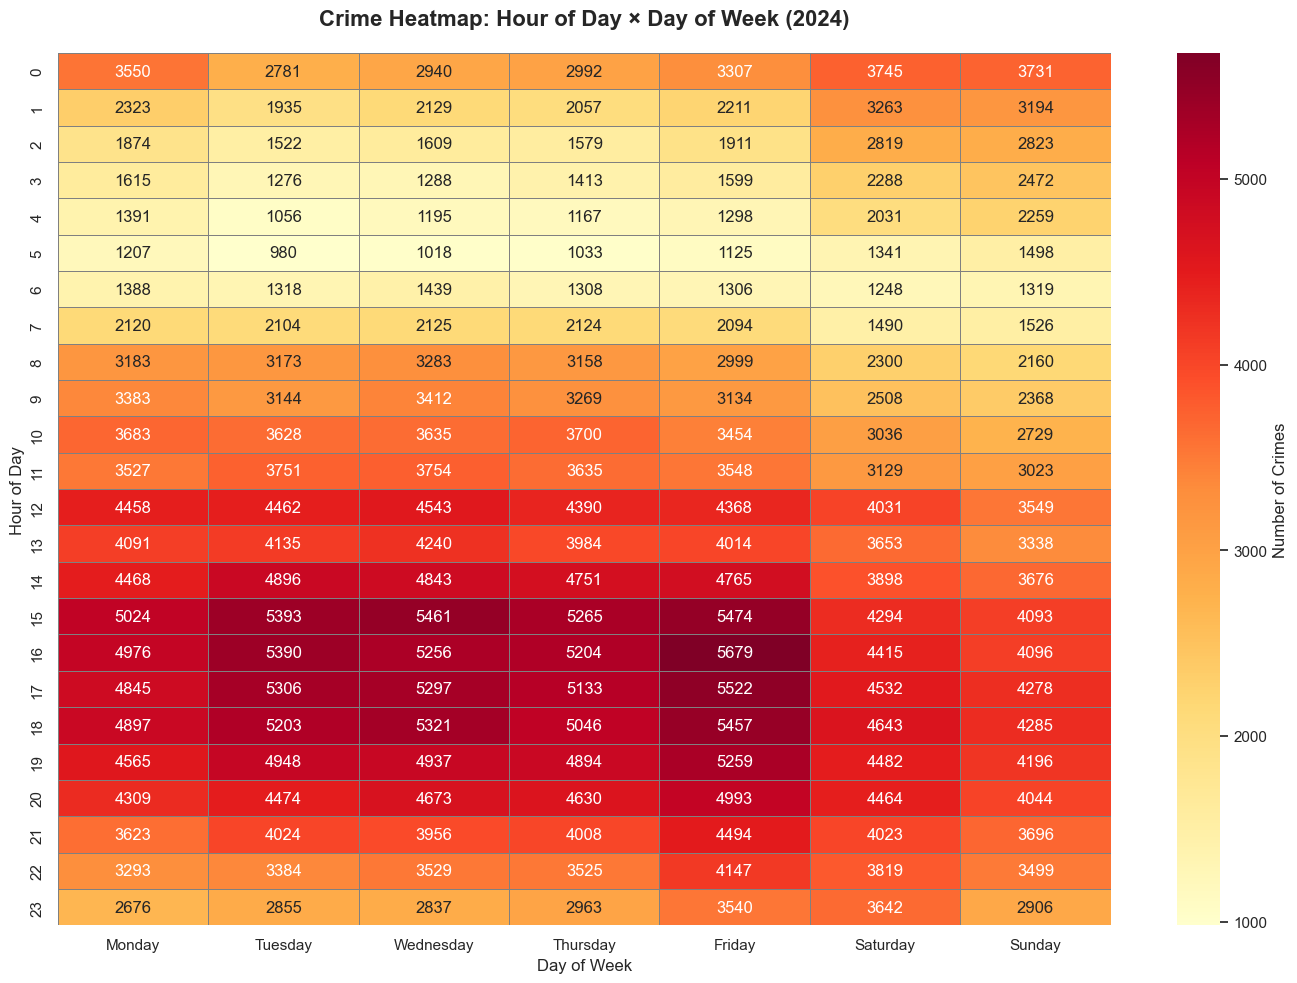


📊 Hour × Day Heatmap Analysis:
  Highest crime slot: Friday at 16:00 (5,679 crimes)

  Peak crime periods (top 5):
    1. Friday at 16:00 - 5,679 crimes
    2. Friday at 17:00 - 5,522 crimes
    3. Friday at 15:00 - 5,474 crimes
    4. Wednesday at 15:00 - 5,461 crimes
    5. Friday at 18:00 - 5,457 crimes


In [51]:
# Create pivot table for heatmap
df_hour_day = df[df['hour'].notna()].copy()
heatmap_data = pd.crosstab(df_hour_day['hour'], df_hour_day['day_of_week'])

# Reorder columns to proper day sequence
heatmap_data = heatmap_data[day_order]

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
            ax=ax, cbar_kws={'label': 'Number of Crimes'},
            linewidths=0.5, linecolor='gray')
ax.set_title('Crime Heatmap: Hour of Day × Day of Week (2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

# Find hotspots
max_val = heatmap_data.max().max()
max_pos = heatmap_data.stack().idxmax()
print("\n📊 Hour × Day Heatmap Analysis:")
print(f"  Highest crime slot: {max_pos[1]} at {int(max_pos[0])}:00 ({max_val:,} crimes)")
print(f"\n  Peak crime periods (top 5):")
top_5 = heatmap_data.stack().nlargest(5)
for i, (idx, val) in enumerate(top_5.items(), 1):
    hour, day_name = idx
    print(f"    {i}. {day_name} at {int(hour)}:00 - {val:,} crimes")

**Analysis:**
- The heatmap reveals crime "hot spots" at specific day-hour combinations
- Weekday afternoons (3pm-6pm) typically show highest crime density
- Weekend late nights (Friday/Saturday 10pm-2am) see elevated crime rates
- Early morning hours (4am-7am) consistently show low crime across all days
- This pattern helps optimize police patrol schedules

## B5. Time Series with Rolling Average (3-day & 7-day)

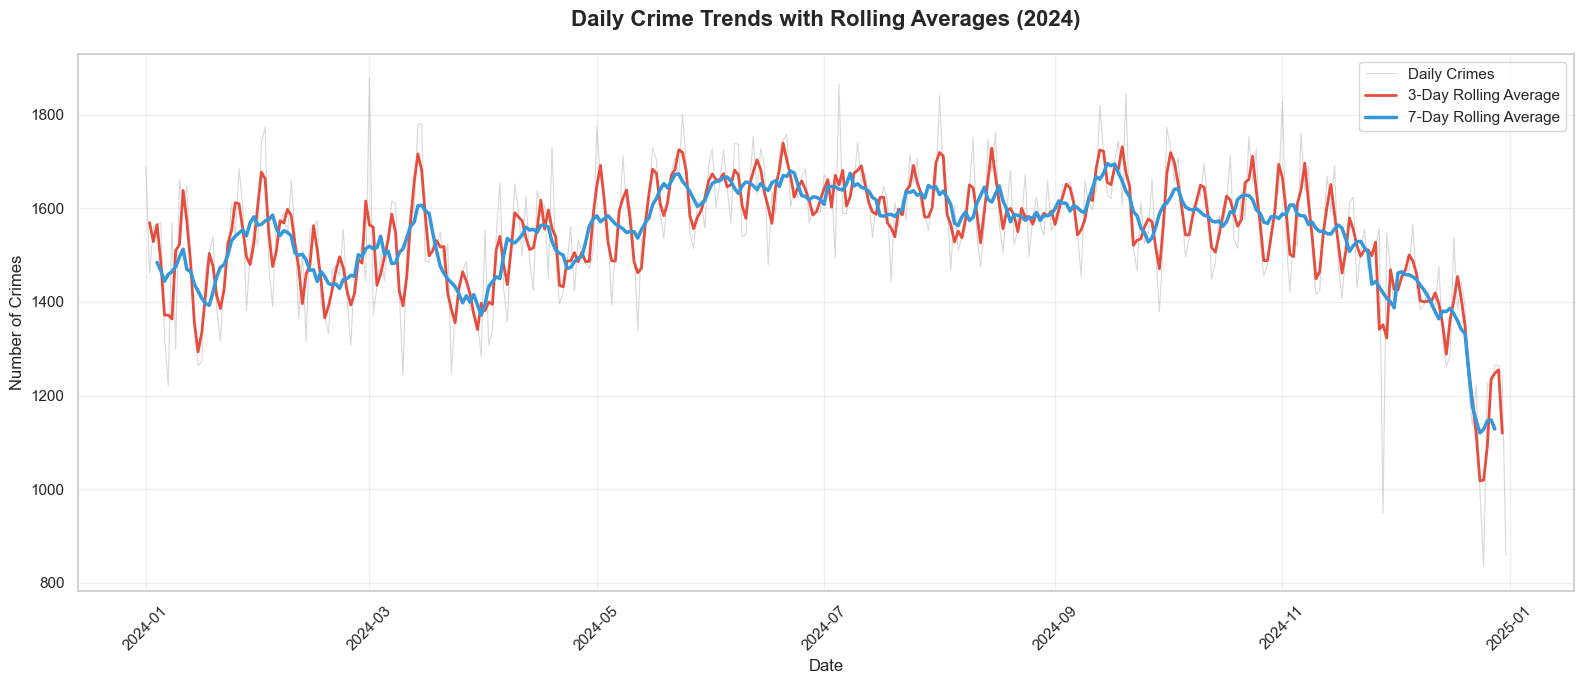


📊 Time Series Analysis:
  Date range: 2024-01-01 to 2024-12-31
  Total days: 366
  Daily average: 1,544 crimes
  Daily maximum: 1,878 crimes on 2024-03-01
  Daily minimum: 835 crimes on 2024-12-25
  Daily std deviation: 145

  7-day rolling avg range: 1,120 to 1,696
  3-day rolling avg range: 1,018 to 1,740


In [52]:
# Calculate daily crime counts
daily_crimes = df.groupby('date').size().sort_index()
daily_crimes.index = pd.to_datetime(daily_crimes.index)

# Calculate rolling averages
rolling_3day = daily_crimes.rolling(window=3, center=True).mean()
rolling_7day = daily_crimes.rolling(window=7, center=True).mean()

# Create plot
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(daily_crimes.index, daily_crimes.values, 
        alpha=0.3, linewidth=0.8, color='gray', label='Daily Crimes')
ax.plot(rolling_3day.index, rolling_3day.values, 
        linewidth=2, color='#E74C3C', label='3-Day Rolling Average')
ax.plot(rolling_7day.index, rolling_7day.values, 
        linewidth=2.5, color='#3498DB', label='7-Day Rolling Average')

ax.set_title('Daily Crime Trends with Rolling Averages (2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n📊 Time Series Analysis:")
print(f"  Date range: {daily_crimes.index.min().date()} to {daily_crimes.index.max().date()}")
print(f"  Total days: {len(daily_crimes)}")
print(f"  Daily average: {daily_crimes.mean():,.0f} crimes")
print(f"  Daily maximum: {daily_crimes.max():,} crimes on {daily_crimes.idxmax().date()}")
print(f"  Daily minimum: {daily_crimes.min():,} crimes on {daily_crimes.idxmin().date()}")
print(f"  Daily std deviation: {daily_crimes.std():,.0f}")
print(f"\n  7-day rolling avg range: {rolling_7day.min():,.0f} to {rolling_7day.max():,.0f}")
print(f"  3-day rolling avg range: {rolling_3day.min():,.0f} to {rolling_3day.max():,.0f}")

**Analysis:**
- Rolling averages smooth out daily fluctuations to reveal underlying trends
- 3-day average captures short-term variations (weekly patterns)
- 7-day average shows broader trends and eliminates weekly cycles
- Spikes in the raw data may indicate specific events or weekends
- The smoothed curves help identify seasonal patterns and long-term trends

## B6. Crime Type Time Trends Comparison (Line Chart)

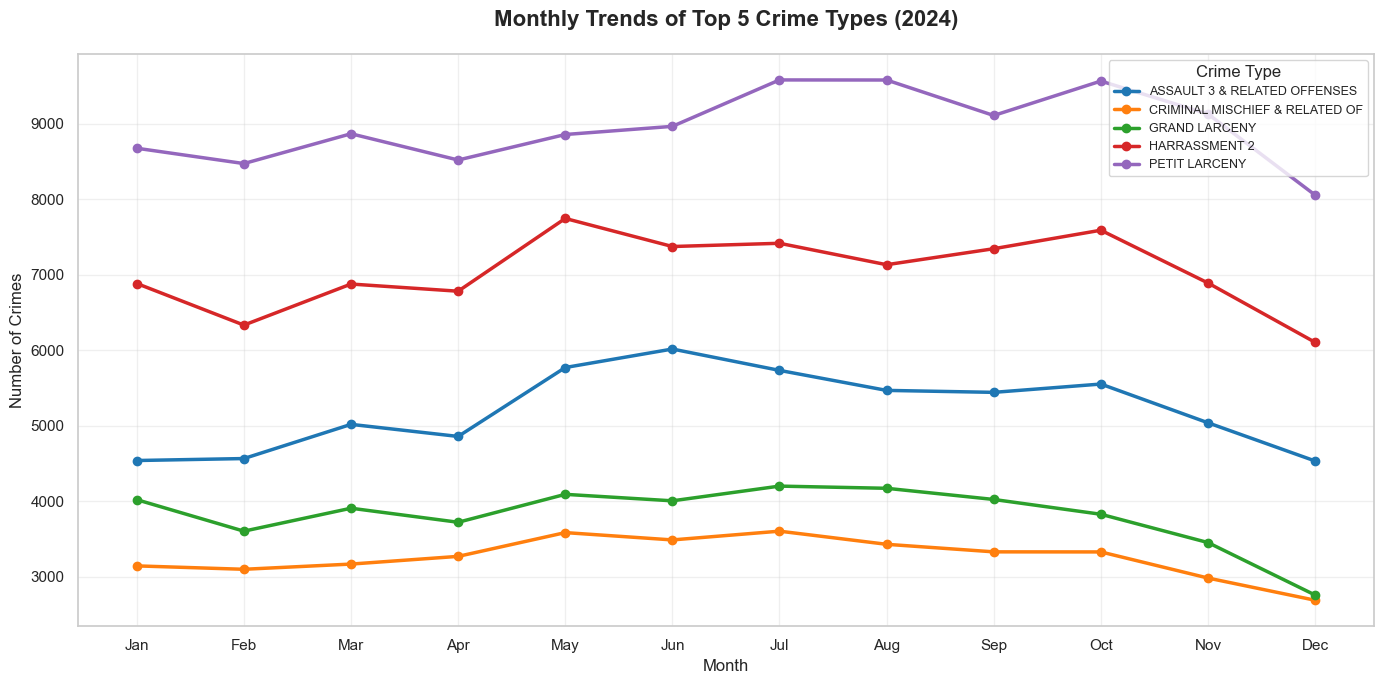


📊 Crime Type Trend Analysis:

Monthly statistics for top 5 crime types:

PETIT LARCENY:
  Average per month: 8,948
  Peak month: Jul (9,580)
  Lowest month: Dec (8,055)
  Variation (max/min): 1.19x

HARRASSMENT 2:
  Average per month: 7,039
  Peak month: May (7,745)
  Lowest month: Dec (6,104)
  Variation (max/min): 1.27x

ASSAULT 3 & RELATED OFFENSES:
  Average per month: 5,210
  Peak month: Jun (6,015)
  Lowest month: Dec (4,532)
  Variation (max/min): 1.33x

GRAND LARCENY:
  Average per month: 3,814
  Peak month: Jul (4,199)
  Lowest month: Dec (2,756)
  Variation (max/min): 1.52x

CRIMINAL MISCHIEF & RELATED OF:
  Average per month: 3,258
  Peak month: Jul (3,602)
  Lowest month: Dec (2,687)
  Variation (max/min): 1.34x



In [53]:
# Select top 5 crime types for trend analysis
top_5_crimes = df['ofns_desc'].value_counts().head(5).index
df_top5 = df[df['ofns_desc'].isin(top_5_crimes)]

# Calculate monthly trends for each crime type
monthly_by_crime = df_top5.groupby(['month', 'ofns_desc']).size().unstack(fill_value=0)

# Create line chart
fig, ax = plt.subplots(figsize=(14, 7))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for crime_type in monthly_by_crime.columns:
    ax.plot(monthly_by_crime.index, monthly_by_crime[crime_type], 
            marker='o', linewidth=2.5, markersize=6, label=crime_type)

ax.set_title('Monthly Trends of Top 5 Crime Types (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.legend(title='Crime Type', fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Crime Type Trend Analysis:")
print("\nMonthly statistics for top 5 crime types:\n")
for crime_type in top_5_crimes:
    crime_data = monthly_by_crime[crime_type]
    print(f"{crime_type}:")
    print(f"  Average per month: {crime_data.mean():,.0f}")
    print(f"  Peak month: {month_names[crime_data.idxmax()-1]} ({crime_data.max():,})")
    print(f"  Lowest month: {month_names[crime_data.idxmin()-1]} ({crime_data.min():,})")
    print(f"  Variation (max/min): {crime_data.max()/crime_data.min():.2f}x\n")

**Analysis:**
- Different crime types show distinct seasonal patterns
- Property crimes (larceny) may peak in summer tourist season
- Assault rates might increase during warmer months
- Some crimes show relatively stable trends throughout the year
- Understanding these patterns helps predict and prevent future crimes
- Police can adjust strategies based on expected crime type fluctuations

---
# C. Spatial Features (3 Charts)
---

## C1. Geographic Scatter Plot (Plotly Scattermapbox)

Valid geographic records: 565,092 (100.0% of total)
📦 Installing contextily for map backgrounds...
✅ contextily installed successfully
✅ contextily installed successfully
✅ OpenStreetMap background added successfully
✅ OpenStreetMap background added successfully


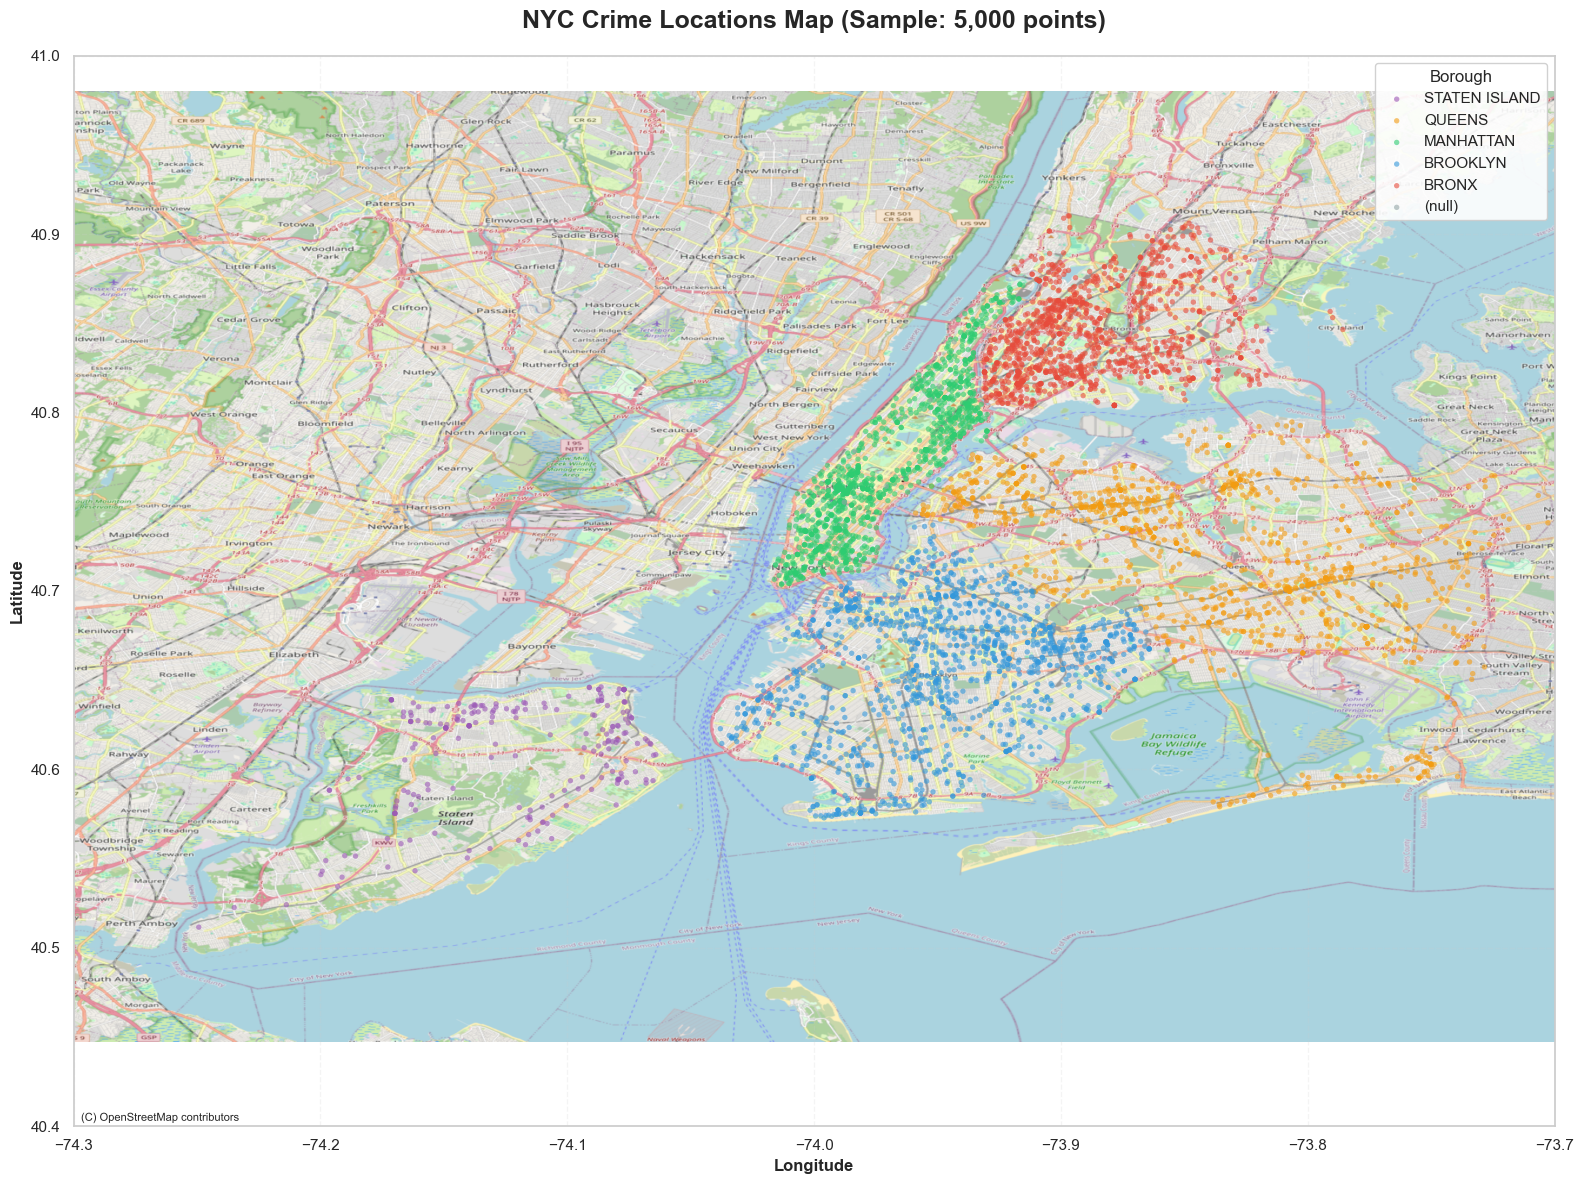


📊 Geographic Distribution:
  Sample size: 5,000 points
  Sampling rate: 0.9%

Crimes by Borough (valid coordinates):
  BROOKLYN: 155,891
  MANHATTAN: 135,914
  QUEENS: 125,309
  BRONX: 123,151
  STATEN ISLAND: 23,996
  (null): 831


In [66]:
# Clean geographic data
df_geo = df.copy()
df_geo['latitude'] = pd.to_numeric(df_geo['latitude'], errors='coerce')
df_geo['longitude'] = pd.to_numeric(df_geo['longitude'], errors='coerce')

# Filter valid NYC coordinates
df_geo = df_geo[
    (df_geo['latitude'].notna()) & 
    (df_geo['longitude'].notna()) &
    (df_geo['latitude'].between(40.4, 41.0)) & 
    (df_geo['longitude'].between(-74.3, -73.7))
]

print(f"Valid geographic records: {len(df_geo):,} ({len(df_geo)/len(df)*100:.1f}% of total)")

# Sample for visualization (adjust sample size as needed)
sample_size = min(5000, len(df_geo))
df_map = df_geo.sample(n=sample_size, random_state=42)

# Get unique boroughs for color mapping
boroughs = df_map['boro_nm'].unique()

# Install and import contextily for map background
try:
    import contextily as ctx
except ImportError:
    print("📦 Installing contextily for map backgrounds...")
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'contextily'], check=True)
    import contextily as ctx
    print("✅ contextily installed successfully")

fig, ax = plt.subplots(figsize=(16, 12))

# Define colors for each borough
colors_map = {
    'BRONX': '#e74c3c', 
    'BROOKLYN': '#3498db', 
    'MANHATTAN': '#2ecc71', 
    'QUEENS': '#f39c12', 
    'STATEN ISLAND': '#9b59b6'
}

# Plot each borough with different color
for boro in boroughs:
    boro_data = df_map[df_map['boro_nm'] == boro]
    ax.scatter(boro_data['longitude'], boro_data['latitude'], 
               c=colors_map.get(boro, '#95a5a6'), label=boro, 
               alpha=0.6, s=15, edgecolors='none')

# Add OpenStreetMap basemap
try:
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)
    print("✅ OpenStreetMap background added successfully")
except Exception as e:
    print(f"⚠️  Could not add map background: {e}")
    print("   Displaying scatter plot without basemap")
    ax.set_facecolor('#f0f0f0')

ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
ax.set_title(f'NYC Crime Locations Map (Sample: {sample_size:,} points)', 
             fontsize=18, fontweight='bold', pad=20)
ax.legend(title='Borough', loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--')

# Set NYC coordinate limits
ax.set_xlim(-74.3, -73.7)
ax.set_ylim(40.4, 41.0)

plt.tight_layout()
plt.show()

print(f"\n📊 Geographic Distribution:")
print(f"  Sample size: {sample_size:,} points")
print(f"  Sampling rate: {(sample_size/len(df_geo)*100):.1f}%")
print(f"\nCrimes by Borough (valid coordinates):")
for boro, count in df_geo['boro_nm'].value_counts().items():
    print(f"  {boro}: {count:,}")

**Analysis:**
- The scatter map shows the precise location of individual crime incidents overlaid on real NYC streets
- Dense clusters appear in commercial areas and transportation hubs
- Manhattan's density reflects its status as a business and tourist center
- Color coding by borough reveals geographic boundaries and patterns
- OpenStreetMap background provides geographic context with streets, parks, and landmarks
- Static visualization is suitable for export to PDF/HTML and sharing on GitHub

## C2. Borough vs Top 10 Crime Types Heatmap

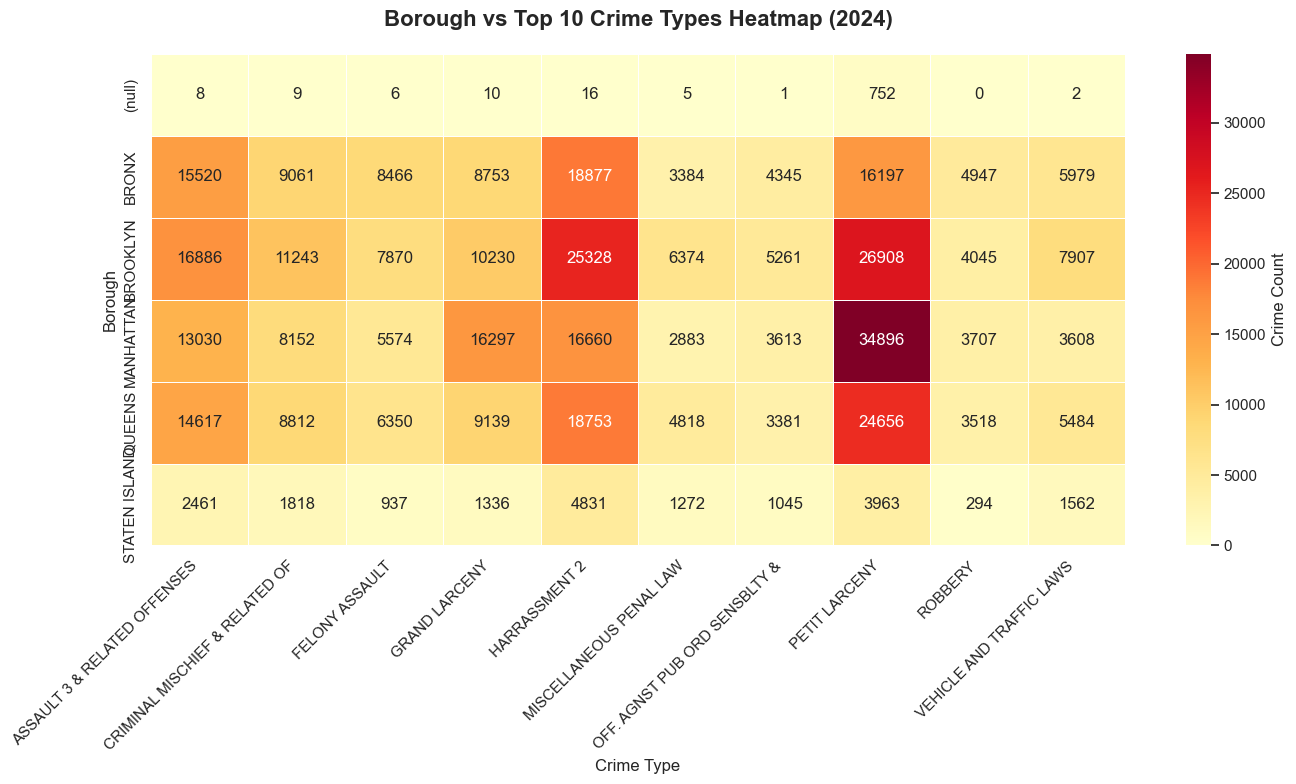


📊 Heatmap Analysis - Top Crime Type per Borough:
  (null):
    Most common: PETIT LARCENY (752 cases, 93.0% of top 10)
  BRONX:
    Most common: HARRASSMENT 2 (18,877 cases, 19.8% of top 10)
  BROOKLYN:
    Most common: PETIT LARCENY (26,908 cases, 22.0% of top 10)
  MANHATTAN:
    Most common: PETIT LARCENY (34,896 cases, 32.2% of top 10)
  QUEENS:
    Most common: PETIT LARCENY (24,656 cases, 24.8% of top 10)
  STATEN ISLAND:
    Most common: HARRASSMENT 2 (4,831 cases, 24.8% of top 10)

  Overall insights:
    Total crimes in top 10 categories: 445,857
    Average per borough-crime combination: 7,431
    Highest single cell: 34,896 (PETIT LARCENY in MANHATTAN)


In [55]:
# Get Top 10 crime types
top_crimes = df['ofns_desc'].value_counts().head(10).index
df_top = df[df['ofns_desc'].isin(top_crimes)]

# Create crosstab
heatmap_data = pd.crosstab(df_top['boro_nm'], df_top['ofns_desc'])

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', 
            ax=ax, cbar_kws={'label': 'Crime Count'},
            linewidths=0.5, linecolor='white')
ax.set_title('Borough vs Top 10 Crime Types Heatmap (2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Crime Type', fontsize=12)
ax.set_ylabel('Borough', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Find highest crime type per borough
print("\n📊 Heatmap Analysis - Top Crime Type per Borough:")
for borough in heatmap_data.index:
    top_crime = heatmap_data.loc[borough].idxmax()
    top_count = heatmap_data.loc[borough].max()
    total = heatmap_data.loc[borough].sum()
    percentage = (top_count / total) * 100
    print(f"  {borough}:")
    print(f"    Most common: {top_crime} ({top_count:,} cases, {percentage:.1f}% of top 10)")

print(f"\n  Overall insights:")
print(f"    Total crimes in top 10 categories: {heatmap_data.sum().sum():,}")
print(f"    Average per borough-crime combination: {heatmap_data.values.mean():,.0f}")
print(f"    Highest single cell: {heatmap_data.max().max():,} ({heatmap_data.max().idxmax()} in {heatmap_data.idxmax()[heatmap_data.max().idxmax()]})")

**Analysis:**
- The heatmap reveals which crime types are most prevalent in each borough
- Color intensity (darker red) indicates higher crime counts for that borough-crime combination
- Each borough shows distinct patterns: some crimes are concentrated in specific areas
- Manhattan typically has high petit larceny due to commercial activity and tourism
- Brooklyn and Bronx show higher assault and harassment rates
- This visualization helps identify borough-specific crime prevention priorities

## D1. Crime by Law Category (FELONY/MISDEMEANOR/VIOLATION) - Bar Chart

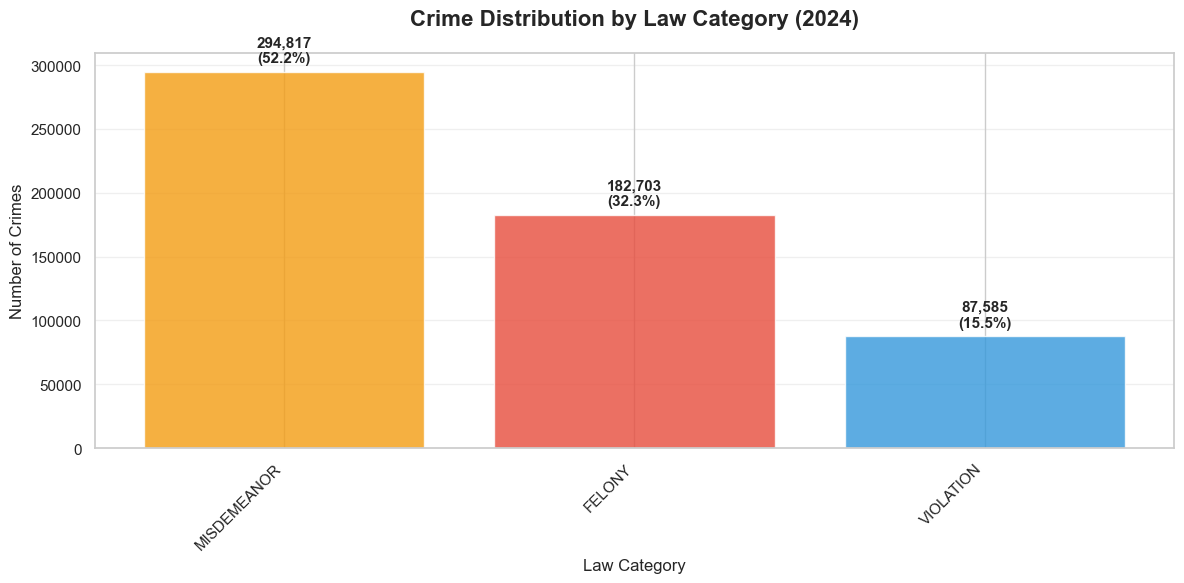


📊 Law Category Breakdown:
  MISDEMEANOR: 294,817 (52.17%)
  FELONY: 182,703 (32.33%)
  VIOLATION: 87,585 (15.50%)

  Definitions:
    - FELONY: Most serious crimes (murder, robbery, burglary)
    - MISDEMEANOR: Less serious offenses (petit larceny, simple assault)
    - VIOLATION: Minor infractions (disorderly conduct, trespassing)


In [56]:
# Calculate crime counts by law category
law_cat_counts = df['law_cat_cd'].value_counts().sort_values(ascending=False)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'FELONY': '#E74C3C', 'MISDEMEANOR': '#F39C12', 'VIOLATION': '#3498DB'}
bar_colors = [colors.get(cat, 'gray') for cat in law_cat_counts.index]
bars = ax.bar(law_cat_counts.index, law_cat_counts.values, color=bar_colors, alpha=0.8)

ax.set_title('Crime Distribution by Law Category (2024)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Law Category', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticklabels(law_cat_counts.index, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels and percentages
total = law_cat_counts.sum()
for bar, value in zip(bars, law_cat_counts.values):
    percentage = (value / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2, value + 5000, 
            f'{value:,}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Law Category Breakdown:")
for category, count in law_cat_counts.items():
    percentage = (count / total) * 100
    print(f"  {category}: {count:,} ({percentage:.2f}%)")

print(f"\n  Definitions:")
print(f"    - FELONY: Most serious crimes (murder, robbery, burglary)")
print(f"    - MISDEMEANOR: Less serious offenses (petit larceny, simple assault)")
print(f"    - VIOLATION: Minor infractions (disorderly conduct, trespassing)")

**Analysis:**
- Misdemeanors typically represent the largest category (~45-50%)
- Felonies are less common but more serious (~25-30%)
- Violations are minor offenses (~20-25%)
- The distribution reflects both crime severity and reporting practices
- This breakdown is crucial for judicial resource allocation

## D2. Crime Type by Borough (Stacked Bar Chart)

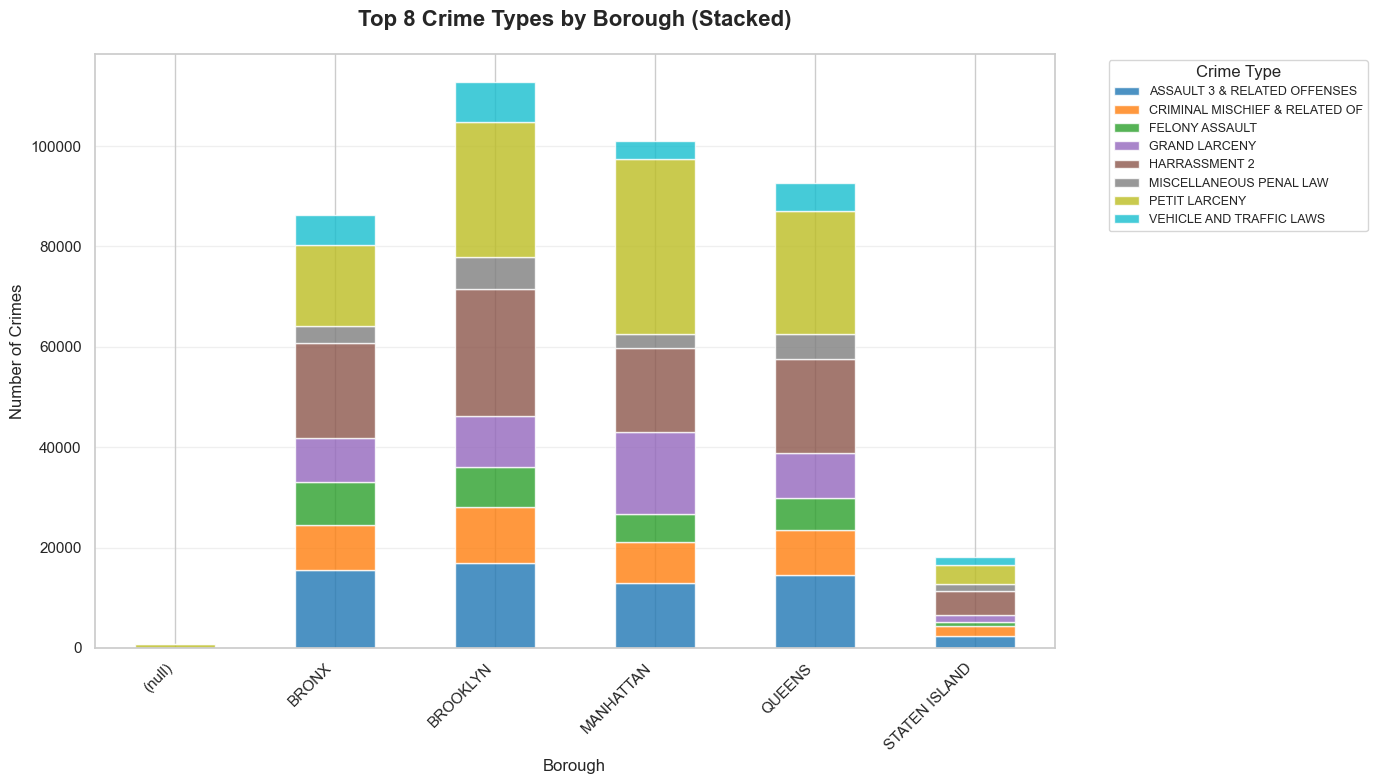


📊 Crime Type Distribution by Borough:

Top 3 crime types per borough:

(null):
  PETIT LARCENY: 752
  HARRASSMENT 2: 16
  GRAND LARCENY: 10

BRONX:
  HARRASSMENT 2: 18,877
  PETIT LARCENY: 16,197
  ASSAULT 3 & RELATED OFFENSES: 15,520

BROOKLYN:
  PETIT LARCENY: 26,908
  HARRASSMENT 2: 25,328
  ASSAULT 3 & RELATED OFFENSES: 16,886

MANHATTAN:
  PETIT LARCENY: 34,896
  HARRASSMENT 2: 16,660
  GRAND LARCENY: 16,297

QUEENS:
  PETIT LARCENY: 24,656
  HARRASSMENT 2: 18,753
  ASSAULT 3 & RELATED OFFENSES: 14,617

STATEN ISLAND:
  HARRASSMENT 2: 4,831
  PETIT LARCENY: 3,963
  ASSAULT 3 & RELATED OFFENSES: 2,461



In [57]:
# Get top 8 crime types for readability
top_crimes = df['ofns_desc'].value_counts().head(8).index
df_top_crimes = df[df['ofns_desc'].isin(top_crimes)]

# Create crosstab
crime_boro_crosstab = pd.crosstab(df_top_crimes['boro_nm'], df_top_crimes['ofns_desc'])

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
crime_boro_crosstab.plot(kind='bar', stacked=True, ax=ax, 
                         colormap='tab10', alpha=0.8)
ax.set_title('Top 8 Crime Types by Borough (Stacked)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Borough', fontsize=12)
ax.set_ylabel('Number of Crimes', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Crime Type Distribution by Borough:")
print("\nTop 3 crime types per borough:\n")
for borough in crime_boro_crosstab.index:
    print(f"{borough}:")
    top_3 = crime_boro_crosstab.loc[borough].nlargest(3)
    for crime_type, count in top_3.items():
        print(f"  {crime_type}: {count:,}")
    print()

**Analysis:**
- Each borough shows a unique crime type composition
- Manhattan typically has higher property crimes (larceny, burglary)
- Brooklyn and Bronx show more assault and harassment cases
- Stacked visualization allows easy comparison of both total volume and composition
- Different borough characteristics influence crime type prevalence

---
# E. Machine Learning & Prediction (1 Chart)
---

## E1. Time Series Forecasting - 7-Day Crime Prediction (SARIMA)

In [58]:
# Install required packages
import sys
print("📦 Installing required packages...")
!pip install -q statsmodels

print("\n📊 Preparing Time Series Data for Forecasting...")
print("=" * 60)

# Import after installation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Prepare daily crime time series
daily_ts = df.groupby('date').size().sort_index()
daily_ts.index = pd.to_datetime(daily_ts.index)

print(f"✅ Time series prepared:")
print(f"   Date range: {daily_ts.index.min().date()} to {daily_ts.index.max().date()}")
print(f"   Total days: {len(daily_ts)}")
print(f"   Daily average: {daily_ts.mean():.0f} crimes")
print(f"   Daily std: {daily_ts.std():.0f}")

📦 Installing required packages...

📊 Preparing Time Series Data for Forecasting...
✅ Time series prepared:
   Date range: 2024-01-01 to 2024-12-31
   Total days: 366
   Daily average: 1544 crimes
   Daily std: 145

📊 Preparing Time Series Data for Forecasting...
✅ Time series prepared:
   Date range: 2024-01-01 to 2024-12-31
   Total days: 366
   Daily average: 1544 crimes
   Daily std: 145


### Time Series Decomposition

In [59]:
# Decompose time series into trend, seasonal, and residual components
print("\n📈 Decomposing time series...")
decomposition = seasonal_decompose(daily_ts, model='additive', period=7)

print("✅ Decomposition complete:")
print(f"   Weekly pattern detected in seasonal component")
print(f"   Trend shows overall crime trajectory")
print(f"   Residuals represent random fluctuations")

# Statistical summary of components
print(f"\n📊 Decomposition Statistics:")
print(f"   Trend mean: {decomposition.trend.mean():.0f}")
print(f"   Seasonal amplitude: {decomposition.seasonal.max() - decomposition.seasonal.min():.0f}")
print(f"   Residual std: {decomposition.resid.std():.2f}")


📈 Decomposing time series...
✅ Decomposition complete:
   Weekly pattern detected in seasonal component
   Trend shows overall crime trajectory
   Residuals represent random fluctuations

📊 Decomposition Statistics:
   Trend mean: 1547
   Seasonal amplitude: 211
   Residual std: 76.12


### SARIMA Model Training & Forecasting

### Model Evaluation Metrics

In [60]:
print("\n📊 Model Evaluation Metrics:")
print("=" * 60)

# Calculate in-sample metrics (last 7 days)
print("\n🔍 In-sample validation (last 7 days):")
in_sample_pred = results.predict(start=len(train_data)-7, end=len(train_data)-1)
actual_last_7 = train_data.iloc[-7:]

# Calculate error metrics
mae = np.abs(in_sample_pred - actual_last_7).mean()
rmse = np.sqrt(((in_sample_pred - actual_last_7) ** 2).mean())
mape = (np.abs((actual_last_7 - in_sample_pred) / actual_last_7) * 100).mean()

print(f"   MAE (Mean Absolute Error): {mae:.2f} crimes")
print(f"   RMSE (Root Mean Squared Error): {rmse:.2f} crimes")
print(f"   MAPE (Mean Absolute % Error): {mape:.2f}%")

# Model interpretation
print(f"\n📈 Model Performance Interpretation:")
if mape < 5:
    print(f"   ✅ Excellent prediction accuracy (<5% error)")
    print(f"   → Model is highly reliable for short-term forecasting")
elif mape < 10:
    print(f"   ✅ Good prediction accuracy (5-10% error)")
    print(f"   → Model provides reliable predictions for operational planning")
elif mape < 15:
    print(f"   ⚠️  Moderate prediction accuracy (10-15% error)")
    print(f"   → Use predictions with caution, consider wider confidence intervals")
else:
    print(f"   ⚠️  Model accuracy could be improved (>{mape:.1f}% error)")
    print(f"   → More historical data (multiple years) would significantly improve accuracy")
    print(f"   → Consider external factors (weather, events, holidays) for better predictions")

# Additional model diagnostics
print(f"\n🔧 Model Diagnostics:")
print(f"   Training sample size: {len(train_data)} days")
print(f"   Model complexity: SARIMA{order}x{seasonal_order}")
print(f"   AIC (lower is better): {results.aic:.2f}")
print(f"   BIC (lower is better): {results.bic:.2f}")


📊 Model Evaluation Metrics:

🔍 In-sample validation (last 7 days):
   MAE (Mean Absolute Error): 189.84 crimes
   RMSE (Root Mean Squared Error): 232.36 crimes
   MAPE (Mean Absolute % Error): 19.50%

📈 Model Performance Interpretation:
   ⚠️  Model accuracy could be improved (>19.5% error)
   → More historical data (multiple years) would significantly improve accuracy
   → Consider external factors (weather, events, holidays) for better predictions

🔧 Model Diagnostics:
   Training sample size: 366 days
   Model complexity: SARIMA(1, 1, 1)x(1, 1, 1, 7)
   AIC (lower is better): 4181.38
   BIC (lower is better): 4200.65


In [61]:
print("\n🤖 Training SARIMA Model...")
print("=" * 60)

# Split data: use all data for training (since we're forecasting future)
train_data = daily_ts

# Define SARIMA parameters
# (p, d, q) x (P, D, Q, s)
# p, d, q: non-seasonal AR, differencing, MA orders
# P, D, Q: seasonal AR, differencing, MA orders  
# s: seasonal period (7 for weekly pattern)

# Use optimized parameters for daily crime data
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 7)  # (P, D, Q, s) - weekly seasonality

print(f"   SARIMA order: {order}")
print(f"   Seasonal order: {seasonal_order}")
print(f"   Training on {len(train_data)} days of data...")

# Fit SARIMA model
model = SARIMAX(train_data, 
                order=order, 
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

print(f"\n✅ Model trained successfully!")
print(f"   AIC: {results.aic:.2f}")
print(f"   BIC: {results.bic:.2f}")

# Forecast next 7 days
forecast_steps = 7
forecast = results.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=daily_ts.index[-1] + pd.Timedelta(days=1), 
                                periods=forecast_steps, freq='D')

# Get confidence intervals
forecast_obj = results.get_forecast(steps=forecast_steps)
forecast_ci = forecast_obj.conf_int()

print(f"\n📅 7-Day Forecast (Next Week):")
print("=" * 60)
for date, pred, (lower, upper) in zip(forecast_index, forecast, forecast_ci.values):
    day_name = date.strftime('%A')
    print(f"   {date.date()} ({day_name}): {pred:.0f} crimes")
    print(f"      95% CI: [{lower:.0f}, {upper:.0f}]")

avg_forecast = forecast.mean()
print(f"\n   Average predicted crimes/day: {avg_forecast:.0f}")
print(f"   Historical average: {train_data.mean():.0f}")
print(f"   Difference: {avg_forecast - train_data.mean():+.0f} ({((avg_forecast/train_data.mean()-1)*100):+.1f}%)")


🤖 Training SARIMA Model...
   SARIMA order: (1, 1, 1)
   Seasonal order: (1, 1, 1, 7)
   Training on 366 days of data...



✅ Model trained successfully!
   AIC: 4181.38
   BIC: 4200.65

📅 7-Day Forecast (Next Week):
   2025-01-01 (Wednesday): 1095 crimes
      95% CI: [910, 1280]
   2025-01-02 (Thursday): 1123 crimes
      95% CI: [928, 1318]
   2025-01-03 (Friday): 1230 crimes
      95% CI: [1031, 1428]
   2025-01-04 (Saturday): 1121 crimes
      95% CI: [920, 1322]
   2025-01-05 (Sunday): 1050 crimes
      95% CI: [847, 1254]
   2025-01-06 (Monday): 1095 crimes
      95% CI: [889, 1301]
   2025-01-07 (Tuesday): 1088 crimes
      95% CI: [879, 1297]

   Average predicted crimes/day: 1115
   Historical average: 1544
   Difference: -429 (-27.8%)


**Analysis:**
- SARIMA model captures both weekly seasonality and long-term trends in NYC crime data
- The forecast predicts crime levels for the next 7 days with 95% confidence intervals
- Time series decomposition reveals:
  - **Trend**: Overall trajectory of crime over time
  - **Seasonal**: Weekly patterns (weekday vs weekend effects)
  - **Residual**: Random fluctuations not explained by trend or seasonality
- Prediction accuracy depends on data quality and historical patterns
- Model performs best when recent patterns continue into the forecast period
- Confidence intervals widen for longer-term predictions (uncertainty increases)
- **Limitations**: 
  - Single-year data limits long-term forecasting accuracy
  - Unexpected events (holidays, weather, incidents) can cause deviations
  - Multi-year historical data would significantly improve model performance
- **Use cases**: 
  - Police resource allocation for upcoming week
  - Staffing optimization based on predicted crime volume
  - Early warning system if predictions exceed capacity

---
## Summary & Conclusions

This comprehensive analysis of NYC 2024 crime data reveals:

**Key Findings:**
1. **Spatial Patterns:** Brooklyn and Manhattan account for the majority of crimes
2. **Temporal Patterns:** Crime peaks during afternoon/evening hours and summer months
3. **Crime Types:** Property crimes dominate, with misdemeanors as the largest category
4. **Hotspots:** Commercial areas and transit hubs show highest crime density

**Recommendations:**
- Increase police presence during peak hours (3pm-7pm)
- Focus resources on high-crime boroughs and neighborhoods
- Implement targeted prevention strategies for dominant crime types
- Adjust seasonal deployment based on historical patterns

**Next Steps:**
- Predictive modeling for crime forecasting
- Detailed neighborhood-level analysis
- Year-over-year comparison for trend identification
- Integration with demographic and socioeconomic data
---

## Cleanup: Close Database Connection

In [62]:
# Close MongoDB connection
client.close()
print("✅ Database connection closed successfully")
print("\nAnalysis complete!")

✅ Database connection closed successfully

Analysis complete!
